In [17]:
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 29 12:36:03 2022

@author: bene-
"""

import numpy as np
from  math import *
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.special as sp
import mpmath as mp

N_x=10
N_y=10
h=0.0
T=1
J=0.5/T

In [18]:
def init_2D(): 
    global N_x
    global N_y
    lattice = np.zeros((N_x,N_y))
    return lattice

Creates a $N_xxN_y$ Array which will be the lattice. 

In [19]:
def step(lattice): #Does one step in the Markov-Chain and return the next constallation 
    global N_x
    global N_y
    global J
    global T           
    beta=1/T 
    for i in range (N_x):
        M=i
        for j in range (N_y):
                N=j #selects a random sin in the cain 
                if np.random.rand()>0.5:#generates a new random orientation of the spin 
                    spin_new=1
                else:
                    spin_new=-1 
                delta_H=calc_delta_H(lattice,M,N,spin_new) #calculates the energy difference from the old an new constallation 
                if delta_H<0:
                    lattice[M,N]=spin_new
                else:
                    if np.exp(-beta * delta_H)>np.random.rand():
                        lattice[M,N]=spin_new
    return(lattice)

Input: $N_xxN_y$ Array (lattice); Output: $N_xxN_y$ Array (lattice after one step)  
A step in the underlying Markov chain is defined by a complete loop of the lattice. Every spin on the lattice is randomly changed. This change is accepted if the energy of the new configuration is lower than before and if the energy for the new configuration is higher than before, the new configuration is only accepted if the Boltzmann probability is larger than a randomly drawn number between $0$ and $1$.


In [20]:
def calc_delta_H(lattice,M,N,spin_new):
    global J
    global N_x
    global N_y
    global h

    spin_old=lattice[M][N]
    delta_H=0
    delta_H+=J* (lattice[(M-1)%(N_x)][N] * spin_new) \
                    -J* (lattice[(M-1)%(N_x)][N] * spin_old)
    delta_H+=J* (lattice[(M+1)%(N_x)][N] * spin_new) \
                    -J* (lattice[(M+1)%(N_x)][N] * spin_old)  
    delta_H+=J* (lattice[M][(N-1)%(N_y)] * spin_new) \
                    -J* (lattice[M][(N-1)%(N_y)] * spin_old)   
    delta_H+=J* (lattice[M][(N+1)%(N_y)] * spin_new) \
                    -J* (lattice[M][(N+1)%(N_y)] * spin_old) 
    delta_H+=h*(spin_new-spin_old)
    
    return -delta_H

Input: $N_xxN_y$ Array (lattice), Position of the changed spin (M,N), value of the changed spin (spin_new); Output: Energy difference from old and new configuration.   
The cost of the energy-calculation for the entire configuration scales -in our case- with $5\cdot (N_x\cdot N_y)$ which is $\mathcal{O}(N_x\cdot N_y)$.  
Thats why calculating the complete energy for both configurations is very costly. We can use the fact, that two subsequent configurations only differ in the value of one spin. This spin only has $4$ neighbors and therefor its enough to calculate the energy difference taking these $4$ spins into account as well as the effect of the external magnetic field. The cost of calculating the change in energy than shrinks to: $\mathcal{O}(1)$.  
The calculation itself is straight forward and the periodic boundary conditions are implemented through the Modulo calculations. 

In [21]:
def calc_magn (lattice): 
    global N_x
    global N_y

    M=0
    M=np.sum(lattice)
    return M/(N_x*N_y)

Input: $N_xxN_y$ Array (lattice); Output: Magnetization per Spin  


In [22]:
def calc_eps(lattice):
    global N_x
    global N_y
    global h
    global J
    
    E=0.0
    rolled1=np.roll(lattice,1,axis=1)
    rolled2=np.roll(lattice,-1,axis=1)
    rolled3=np.transpose(np.roll(np.transpose(lattice),1,axis=1))
    rolled4=np.transpose(np.roll(np.transpose(lattice),-1,axis=1))    
    E+=-J*np.sum(np.multiply(rolled1,lattice))
    E+=-J*np.sum(np.multiply(rolled2,lattice))
    E+=-J*np.sum(np.multiply(rolled3,lattice))
    E+=-J*np.sum(np.multiply(rolled4,lattice))
    E+=-h*np.sum(lattice)

    return E/(N_x*N_y)

Input: $N_xxN_y$ Array (lattice); Output: Energy per Spin  
As mentioned above the energy calculation for the entire lattice is very costly. For larger lattices we would recommend to keep track of the entire energy of the lattice by saving the energy changes calculated by *calc_delta_H*. For the small values of $N_x$ and $N_y$ we are looking at, the direct calculation is still viable.  
We create four new versions of the lattice which are individually rolled in each possible direction (periodic boundary conditions are taken into account correctly by this method). By taking the direct multiplication (no matrix-multiplication) we can calculate the energy for the entire configuration in each direction pretty quickly. 

In [23]:
def eps_theo():
    global J

    A=mp.sech(2*J)**2
    B=mp.tanh(2*J)**2

    return -2*J*mp.coth(2*J)*(1+(2/np.pi)*(2*(mp.tanh(2*J)**2)-1)\
                              *mp.ellipk(4*A*B)) 

Input: None; Output: Theoretical value of energy per Spin in the thermodynamic limit.  
    

In [24]:
def abs_m_theo():
    global J
    if J>0.4406867935:
        return (1-(1/mp.sinh(2*J)**4))**(1/8)
    else: 
        return 0 

Input: None; Output: Theoretical value of magnetization per Spin in the thermodynamic limit.  
    

In [25]:
def m_h_5():
    global N_x
    global N_y
    global h
    E=20 #amount of points for the graph
    I=10 #initialization
    A=2 #autocorrelationcorrection
    C=100 #Number of components for an ensemble
    D=5
    final_M=np.zeros(E+1) 
    M=0
    lattice=init_2D()
    colours=['b','g','r','c','m','y','k']    
    for m in range(D):       
        N_x=N_y=(m+1)*4
        final_M=np.zeros(E+1)
        for j in range(E+1):
            h=-1+(j/10)
            lattice=init_2D()
            for i in range(I): 
                (lattice)=step(lattice)
            for k in range(C):
                for i in range(A):
                    (lattice)=step(lattice)
                M+=calc_magn(lattice)
            final_M[j]=M/C
            M=0
        plt.plot(np.arange(-1.0,1.1,0.1),final_M,color=colours[m+1],\
                 label='$N_x=N_y=$%s'%str((m+1)*4))
    plt.legend()
    plt.xlabel(r"$h$")
    plt.ylabel(r"$m(h)$")
    plt.show()
    

Input: None; Output: None  
This function calculates the thermodynamically expected value of the magnetization per spin. This is done for $N_x=N_y\in [4,20]$ and $h\in [-1,1]$ and $J=0.5$. We plot our results as shown below.   
We can see that the magnetization highly depends on $h$. This is because the spins align according to the external magnetic field as long as the coupling $J$ is strong enough and the temperature $T$ is low enough. For the sake of dimensionlessness we use the $[J]=\frac{1}{T}$ and therefor $J=0.5$ fulfills these conditions. 

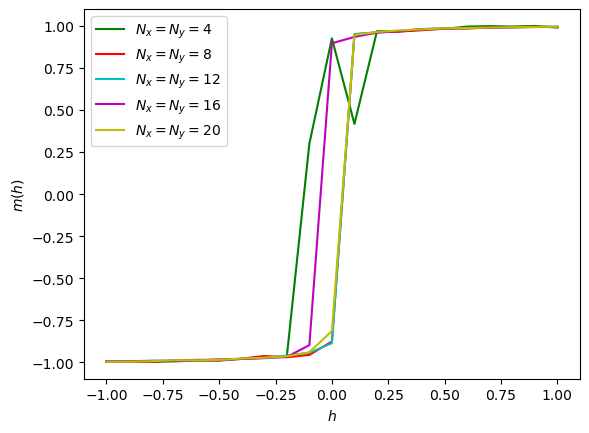

In [26]:
m_h_5()

In [27]:
def eps_J_6():
    global N_x
    global N_y
    global h
    global J
    

    E=16 #amount of points for the graph
    I=10 #initialization
    A=2 #autocorrelationcorrection
    C=100 #Number of components for an ensemble
    D=5
    lattice=init_2D()
    colours=['b','g','r','c','m','y','k']   
    h=0.0
    final_eps=np.zeros(E)
    eps_theo_array=np.zeros(E)
    for i in range(E):
        J=0.25+(i*0.75/(E-1))
        eps_theo_array[i]=eps_theo()

    for m in range(D):       
        N_x=N_y=(m+1)*4
        final_eps=np.zeros(E)
        for j in range(E):
            J=0.25+(j*0.75/(E-1))
            lattice=init_2D()
            En=0
            for i in range(I): 
                (lattice)=step(lattice)
            for k in range(C):
                for i in range(A):
                    (lattice)=step(lattice)
                En+=calc_eps(lattice)
            final_eps[j]=En/C
        plt.plot(np.arange(0.25,1.05,0.05),final_eps,color=colours[m+1],label='$N_x=N_y=$%s'%str((m+1)*4))
    plt.plot(np.arange(0.25,1.05,0.05),eps_theo_array,label='$N_x=N_y=\infty$ (theo)')
    plt.legend()
    plt.xlabel(r"$J$")
    plt.ylabel(r"$\epsilon (J)$")
    plt.show() 
    

Input: None; Output: None  
This function calculates the thermodynamically expected value of the energy per spin. This is done for $N_x=N_y\in [4,20]$ and $J\in [0.25,1]$ (We don't use $J\in[0.25,2]$ because for $J\in[1,2]$ there is nothing interesting to see and this costs valuable computation time). We set $h=0$. We plot our results as well as the theoretically expected solution in the thermodynamic limit.  
As one can see our result matches the theoretical expected solution very well. A close look a the curve shows a little kink in the area $J\in[0.4,0.5]$. The curve shows a almost linear behaviour which is not surprising because with rising J the spins align pretty quickly and for four nearest neighbors the energy per spin should be close to $4\cdot J$ when $h=0$.

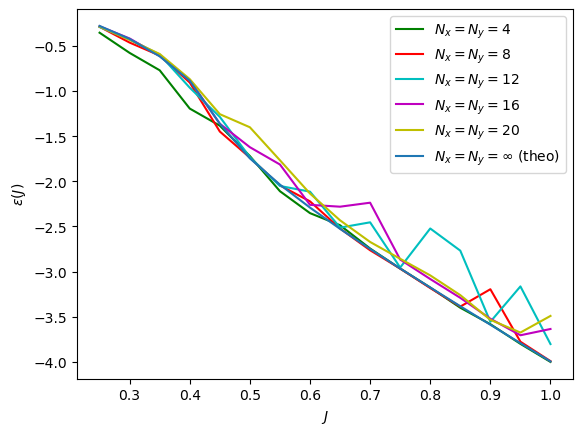

In [28]:
eps_J_6()

In [29]:
def abs_m_J_7():
    global N_x
    global N_y
    global h
    global J
    

    E=16 #amount of points for the graph
    I=10 #initialization
    A=2 #autocorrelationcorrection
    C=100 #Number of components for an ensemble
    D=5
    lattice=init_2D()
    colours=['b','g','r','c','m','y','k']   
    h=0.0
    final=np.zeros(E)
    abs_m_theo_array=np.zeros(E)
    for i in range(E):
        J=0.25+(i*0.75/(E-1))
        abs_m_theo_array[i]=abs_m_theo()
        
        
    for m in range(D):       
        N_x=N_y=(m+1)*4
        final=np.zeros(E)
        for j in range(E):
            J=(0.25+(j*0.75/(E-1)))/T
            lattice=init_2D()
            abs_m=0
            for i in range(I): 
                (lattice)=step(lattice)
            for k in range(C):
                for i in range(A):
                    (lattice)=step(lattice)
                abs_m+=np.abs(calc_magn(lattice))
            final[j]=abs_m/C
        plt.plot((np.arange(0.25,1.05,0.05)/T)**(-1),final,color=colours[m+1],\
                 label='$N_x=N_y=$%s'%str((m+1)*4))
    plt.plot((np.arange(0.25,1.05,0.05)/T)**(-1),abs_m_theo_array,\
             label='$N_x=N_y=\infty$ (theo)')
    plt.legend()
    plt.xlabel(r"$J^{-1}$")
    plt.ylabel(r"$\langle |m|\rangle (J)$")
    plt.show()    

Input: None; Output: None  
This function calculates the thermodynamically expected value of the absolute magnetization per spin. This is done for $N_x=N_y\in [4,20]$ and $J\in [0.25,1]$ . We set $h=0$. We plot our results as a function of $J^{-1}$ as well as the theoretically expected solution in the thermodynamic limit.  
Apparently the calculated expected value of the absolute magnetization per spin converges to the theoretically expected solution for increasing size of the system. Here the significance of the critical coupling-value $J_c$ gets apparent. The critical coupling corresponds to a phasetransition, which is visible in the drastic drop of the absolute magnetization around the critical coupling value. We defined our $J$ as $\frac{J}{T}$ for the dimensionlessness and so $\frac{1}{J_c}$ is therefor also a critical temperature.  
Its important to plot the absolute value of the magnetization here because as we have seen before the magnetization for $h=0$ is always $0$. This is because the system is isotropic in the beginning and would produce a magnetization in a random direction which would cancel out over multiple constellations. 

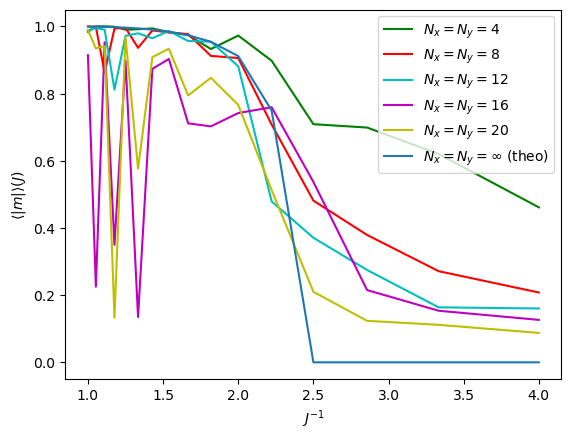

In [30]:
abs_m_J_7()